In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2023-05-28 03:06:01.357184: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 274786941527362693
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23150133248
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18109352764321222002
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:81:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


2023-05-28 03:06:03.936166: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 22077 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:81:00.0, compute capability: 8.9


In [2]:
import os
import numpy as np
from numba import cuda
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import ray
import tensorflow as tf
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from sklearn.model_selection import GridSearchCV
from tune_sklearn import TuneSearchCV
import gc
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

ray.init()
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TF_GPU_ALLOCATOR"] = 'cuda_malloc_async'
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate a specific fraction of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(21658*0.8))])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


from tensorflow.compat.v1 import ConfigProto
config = ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction=0.8

# Load the data
df_train = pd.read_csv('email_data_slim.csv')
df_val = pd.read_csv('processed_validation_data.csv')

# Ensure that there are no NA values in the 'subject' and 'body' columns
df_train = df_train.dropna(subset=['body'])
df_val = df_val.dropna(subset=['body'])

stemmer = PorterStemmer()

def stem_words(text):
    text = str(text)  # Ensure the text is a string
    word_tokens = word_tokenize(text)
    stems = [stemmer.stem(word) for word in word_tokens]
    return ' '.join(stems)

nltk.download('punkt')
df_train['body'] = df_train['body'].apply(stem_words)
df_val['body'] = df_val['body'].apply(stem_words)

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['body'])
sequences_train = tokenizer.texts_to_sequences(df_train['body'])
sequences_val = tokenizer.texts_to_sequences(df_val['body'])
word_index = tokenizer.word_index

max_length = max(max(len(s) for s in sequences_train), max(len(s) for s in sequences_val)) 

# Padding
data_train = pad_sequences(sequences_train, maxlen=max_length)
data_val = pad_sequences(sequences_val, maxlen=max_length)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data_train, df_train['label'], test_size=0.2, random_state=42)

# Define a callback to clear training outputs at the end of every training step
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

class CleanGpuUsage(tf.keras.callbacks.Callback):
    def on_trial_result(self, iteration, trials, trial, result, **info):
        print(f"Got result: {result['metric']}")
        device = cuda.get_current_device()
        device.reset()

# Define a callback to save the model at the best epoch and the last epoch
class SaveModelCallback(tf.keras.callbacks.Callback):
    def __init__(self, models_directory):
        super(SaveModelCallback, self).__init__()
        self.models_directory = models_directory
        self.trial_directory = None
        self.best_epoch = -1

    def on_train_begin(self, logs=None):
        # Create a sub-directory for the current trial
        self.trial_directory = os.path.join(self.models_directory, f'trial_{self.model.trial_id}')
        os.makedirs(self.trial_directory, exist_ok=True)

#     def on_epoch_end(self, epoch, logs=None):
#         model_name = f'model_{epoch}.h5'
#         model_path = os.path.join(self.trial_directory, model_name)
#         self.model.save(model_path)
#         # Save the model at the best epoch
#         if logs is not None and 'val_loss' in logs:
#             current_val_loss = logs['val_loss']
#             if self.best_epoch == -1 or current_val_loss < self.best_val_loss:
#                 self.best_epoch = epoch
#                 self.best_val_loss = current_val_loss
#                 best_model_name = f'best_model.h5'
#                 best_model_path = os.path.join(self.trial_directory, best_model_name)
#                 self.model.save(best_model_path)

    def on_train_end(self, logs=None):
            last_model_name = f'last_model.h5'
            last_model_path = os.path.join(self.trial_directory, last_model_name)
            self.model.save(last_model_path)

# Directory to save the models
models_directory = 'ray_results'

# Specify callbacks
save_model_callback = SaveModelCallback(models_directory)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
callbacks = [ClearTrainingOutput(), early_stopping, save_model_callback]

2023-05-28 03:06:07,298	WARNING utils.py:613 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2023-05-28 03:06:07,301	WARNING utils.py:625 -- Ray currently does not support initializing Raywith fractional cpus. Your num_cpus will be truncated from 30.71999 to 30.
2023-05-28 03:06:07,491	INFO worker.py:1625 -- Started a local Ray instance.
2023-05-28 03:06:08.277255: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22077 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:81:00.0, compute capability: 8.9


1 Physical GPUs, 1 Logical GPUs


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Define a custom Keras model with a trial_id attribute
class CustomKerasModel(Sequential):
    def __init__(self, trial_id, **kwargs):
        super().__init__(**kwargs)
        self.trial_id = trial_id


# Wrap build_model function in a KerasClassifier with the custom model to support saving model on each trial
def build_model(trial_id=None, num_lstm_layers=1, num_dense_layers=1, lstm_units=64, dense_units=64, dropout_rate=0.0, optimizer='adam'):
    model = CustomKerasModel(trial_id=trial_id)
    model.add(Embedding(input_dim=len(word_index)+1, output_dim=128, input_length=max_length))
    for i in range(num_lstm_layers):
        if i == num_lstm_layers - 1:
            model.add(LSTM(lstm_units, return_sequences=False))
        else:
            model.add(LSTM(lstm_units, return_sequences=True))
    for _ in range(num_dense_layers):
        model.add(Dense(dense_units, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [4]:
# Wrap your build_model function in a KerasClassifier
model = KerasClassifier(build_fn=build_model, verbose=1)

# Define the hyperparameters as a dictionary
param_grid = {
    'optimizer': ['RMSprop'],
    'num_lstm_layers': [1, 2],
    'lstm_units': [32, 64, 128],
    'num_dense_layers': [1, 2],
    'dense_units': [32, 64, 128],
    'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'batch_size': [64],
    'epochs': [80]
}

# TuneSearchCV instead of GridSearchCV
tune_search = TuneSearchCV(
    model,
    param_grid,
    early_stopping=False,  # Enables early stopping
    max_iters=1,  # Maximum iterations in the Ray Tune library
    use_gpu=True,  # Allows Ray Tune to use GPU scheduling
    search_optimization="bayesian",  # Type of optimization algorithm
    n_jobs=-1,  # Number of jobs to run concurrently
    cv=2,  # Cross-validation splitting strategy
    verbose=1
)

# Fit the model
# tune_search.fit(X_train, y_train)
tune_search.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[early_stopping, CleanGpuUsage(), save_model_callback], verbose=2)

# Get the best parameters and score
print("Best parameter combination: ", tune_search.best_params_)
print("Best score: ", tune_search.best_score_)


(_Trainable pid=300506) Epoch 1/80
(_Trainable pid=300506) 40/40 - 57s - loss: 0.5593 - accuracy: 0.7663 - val_loss: 0.5084 - val_accuracy: 0.7523 - 57s/epoch - 1s/step
(_Trainable pid=300506) Epoch 2/80
(_Trainable pid=300506) 40/40 - 53s - loss: 0.3684 - accuracy: 0.8492 - val_loss: 0.2615 - val_accuracy: 0.8953 - 53s/epoch - 1s/step
(_Trainable pid=300506) Epoch 3/80
(_Trainable pid=300506) 40/40 - 53s - loss: 0.1654 - accuracy: 0.9426 - val_loss: 0.2172 - val_accuracy: 0.9133 - 53s/epoch - 1s/step
(_Trainable pid=300506) Epoch 4/80
(_Trainable pid=300506) 40/40 - 52s - loss: 0.0890 - accuracy: 0.9734 - val_loss: 0.1776 - val_accuracy: 0.9383 - 52s/epoch - 1s/step
(_Trainable pid=300506) Epoch 5/80
(_Trainable pid=300506) 40/40 - 52s - loss: 0.0400 - accuracy: 0.9894 - val_loss: 0.2223 - val_accuracy: 0.9289 - 52s/epoch - 1s/step
(_Trainable pid=300506) Epoch 6/80
(_Trainable pid=300506) 40/40 - 52s - loss: 0.0234 - accuracy: 0.9945 - val_loss: 0.2323 - val_accuracy: 0.9398 - 52s/ep

2023-05-28 08:00:51,793	INFO tune.py:945 -- Total run time: 17616.17 seconds (17616.13 seconds for the tuning loop).
2023-05-28 08:00:51.926466: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 21.56GiB (23150133248 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 08:00:51.927446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 19.40GiB (20835119104 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 08:00:51.928355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 17.46GiB (18751606784 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 08:00:51.929262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 15.72GiB (16876445696 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 08:00:51.930161: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] fail

Epoch 1/80


2023-05-28 08:00:52.781436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 08:00:52.783007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 08:00:52.784101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

80/80 - 113s - loss: 0.4561 - accuracy: 0.8072 - val_loss: 0.2700 - val_accuracy: 0.9016 - 113s/epoch - 1s/step
Epoch 2/80
80/80 - 98s - loss: 0.2433 - accuracy: 0.9277 - val_loss: 0.1609 - val_accuracy: 0.9398 - 98s/epoch - 1s/step
Epoch 3/80
80/80 - 98s - loss: 0.1045 - accuracy: 0.9684 - val_loss: 0.2072 - val_accuracy: 0.9469 - 98s/epoch - 1s/step
Epoch 4/80
80/80 - 96s - loss: 0.0570 - accuracy: 0.9850 - val_loss: 0.1619 - val_accuracy: 0.9500 - 96s/epoch - 1s/step
Epoch 5/80
80/80 - 97s - loss: 0.0302 - accuracy: 0.9914 - val_loss: 0.1477 - val_accuracy: 0.9555 - 97s/epoch - 1s/step
Epoch 6/80
80/80 - 98s - loss: 0.0219 - accuracy: 0.9932 - val_loss: 0.1531 - val_accuracy: 0.9500 - 98s/epoch - 1s/step
Epoch 7/80
80/80 - 96s - loss: 0.0080 - accuracy: 0.9979 - val_loss: 0.1531 - val_accuracy: 0.9633 - 96s/epoch - 1s/step
Epoch 8/80
80/80 - 95s - loss: 0.0086 - accuracy: 0.9969 - val_loss: 0.1715 - val_accuracy: 0.9539 - 95s/epoch - 1s/step
Epoch 9/80
80/80 - 95s - loss: 0.0051 - a

In [5]:
# Get the best model
best_model = tune_search.best_estimator_.model

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_test, y_test)

print('Test score:', loss)
print('Test accuracy:', accuracy)

# Save the best model
best_model.save('model_final_gridsearch.h5')


2023-05-28 08:25:14.726941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 08:25:14.728814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 08:25:14.729990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 17s 423ms/step - loss: 0.1477 - accuracy: 0.9555
Test score: 0.14766167104244232
Test accuracy: 0.9554687738418579


In [7]:
import json
import pprint

base_directory = 'ray_results'

# Directories of interest
dirs_of_interest = ['_Trainable_2023-05-28_03-07-15']

pp = pprint.PrettyPrinter(indent=4)

for dir_of_interest in dirs_of_interest:
    dirpath = os.path.join(base_directory, dir_of_interest)

    for subdir in os.listdir(dirpath):
        subdir_path = os.path.join(dirpath, subdir)

        # Continue to the next subdir if it's not a directory or does not contain both 'params.json' and 'result.json'
        if not os.path.isdir(subdir_path) or 'params.json' not in os.listdir(subdir_path) or 'result.json' not in os.listdir(subdir_path):
            continue

        with open(os.path.join(subdir_path, 'params.json')) as f:
            params = json.load(f)

        with open(os.path.join(subdir_path, 'result.json')) as f:
            if os.stat(os.path.join(subdir_path, 'result.json')).st_size != 0:
                results = json.load(f)
            else:
                print(f"Empty 'result.json' file in: {os.path.join(subdir_path, 'result.json')}")
                continue

        scores = [value for value in results.values() if isinstance(value, (int, float))]
        if scores:
            mean_score = np.mean(scores)
            std_score = np.std(scores)
            print(f"Avg mean test score: {mean_score}, Std test score: {std_score}\nParameters:")
            pp.pprint(params)
            print("\n---\n")
        else:
            print(f"No numeric scores found in: {os.path.join(subdir_path, 'result.json')}")


Avg mean test score: 140462498.86418918, Std test score: 465769395.41393363
Parameters:
{   'batch_size': 64,
    'cv': 'KFold(n_splits=2, random_state=None, shuffle=False)',
    'dense_units': 64,
    'dropout_rate': 0.3,
    'early_stop_type': 'EarlyStopping.NO_EARLY_STOP',
    'early_stopping': False,
    'epochs': 80,
    'groups': None,
    'lstm_units': 128,
    'max_iters': 1,
    'metric_name': 'average_test_score',
    'n_jobs': 1,
    'num_dense_layers': 1,
    'num_lstm_layers': 1,
    'optimizer': 'RMSprop',
    'return_train_score': False,
    'scoring': {'score': '<function _passthrough_scorer at 0x7ef988214820>'}}

---

Avg mean test score: 140462757.8610088, Std test score: 465769904.0591083
Parameters:
{   'batch_size': 64,
    'cv': 'KFold(n_splits=2, random_state=None, shuffle=False)',
    'dense_units': 64,
    'dropout_rate': 0.3,
    'early_stop_type': 'EarlyStopping.NO_EARLY_STOP',
    'early_stopping': False,
    'epochs': 80,
    'groups': None,
    'lstm_units

40/40 [==============================] - 17s 423ms/step - loss: 0.1477 - accuracy: 0.9555
Test score: 0.14766167104244232
Test accuracy: 0.9554687738418579


2023-05-28 08:26:34.751871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 08:26:34.753336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 08:26:34.754297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 18s 443ms/step


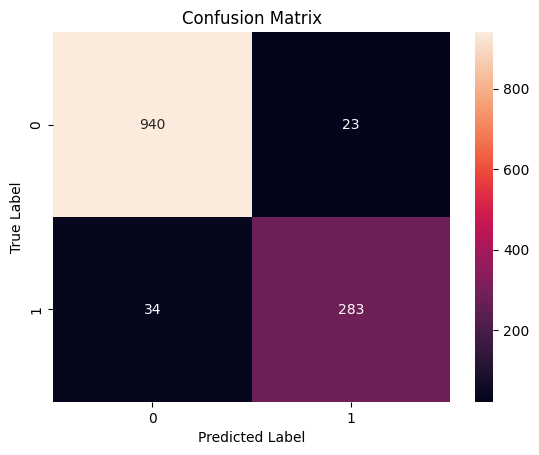

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       963
           1       0.92      0.89      0.91       317

    accuracy                           0.96      1280
   macro avg       0.94      0.93      0.94      1280
weighted avg       0.96      0.96      0.96      1280



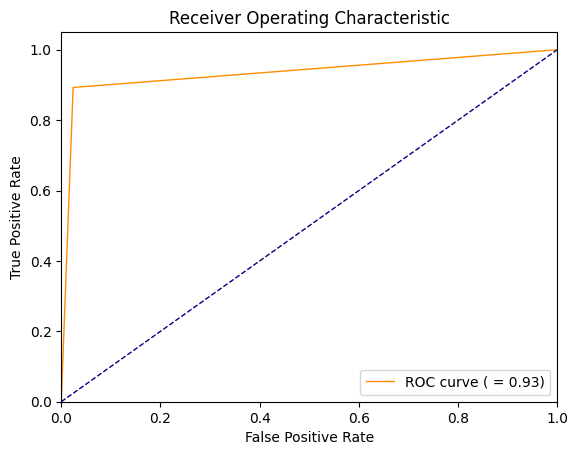

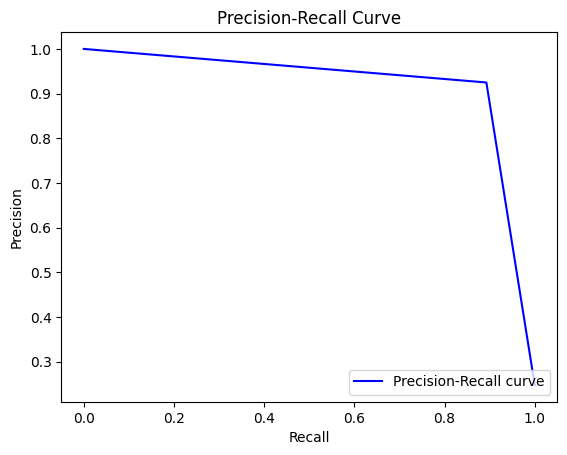

82/82 [==============================] - 35s 422ms/step - loss: 0.4585 - accuracy: 0.8387
Validation score: 0.45852258801460266
Validation accuracy: 0.8387096524238586


2023-05-28 08:27:28.151520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 08:27:28.153014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 08:27:28.153984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 35s 420ms/step


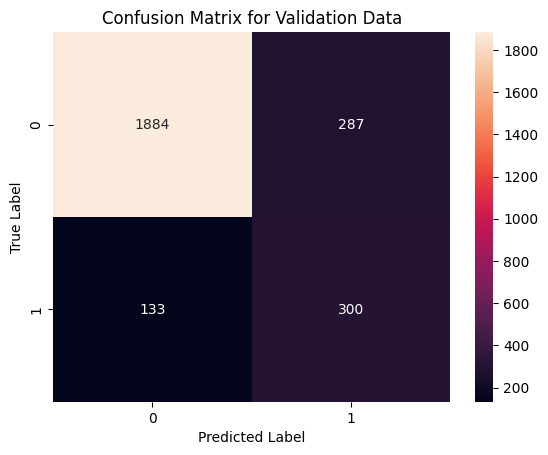

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      2171
           1       0.51      0.69      0.59       433

    accuracy                           0.84      2604
   macro avg       0.72      0.78      0.74      2604
weighted avg       0.86      0.84      0.85      2604



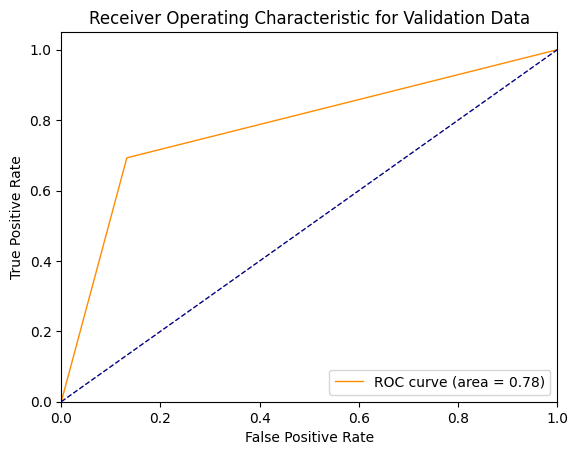

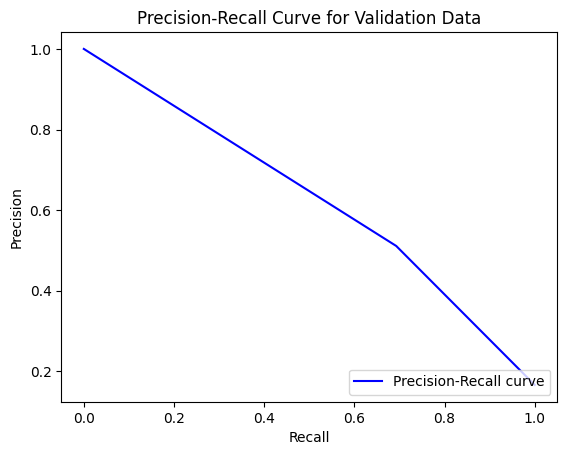

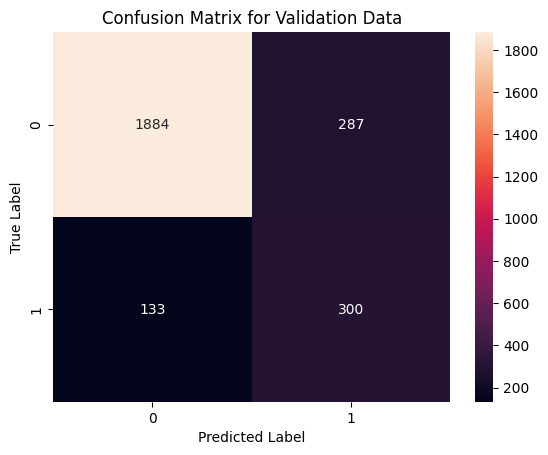

In [8]:
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import learning_curve    

# Evaluate the best model
score, acc = best_model.evaluate(X_test, y_test)

print('Test score:', score)
print('Test accuracy:', acc)

# Predictions
predictions = (best_model.predict(X_test) > 0.5).astype('int32')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plotting Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification report
print(classification_report(y_test, predictions))

# ROC Curve and AUC for the test set
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve ( = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
plt.plot(recall, precision, color='blue', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

## Learning Curve comment as model don't have a score
# train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5)
# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)
# plt.figure()
# plt.title("Learning Curve")
# plt.xlabel("Training Examples")
# plt.ylabel("Score")
# plt.ylim((0.0, 1.1))
# plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
# plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
# plt.legend(loc="best")
# plt.show()

## Validation set
# Evaluate the model on the validation data
val_score, val_acc = best_model.evaluate(data_val, df_val['label'])

print('Validation score:', val_score)
print('Validation accuracy:', val_acc)

# Predictions on the validation data
val_predictions = (best_model.predict(data_val) > 0.5).astype('int32')

# Confusion matrix for validation data
conf_matrix_val = confusion_matrix(df_val['label'], val_predictions)

# Plotting Confusion Matrix for validation data
sns.heatmap(conf_matrix_val, annot=True, fmt="d")
plt.title("Confusion Matrix for Validation Data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification report for validation data
print(classification_report(df_val['label'], val_predictions))

# ROC Curve and AUC for the validation data
fpr_val, tpr_val, thresholds_val = roc_curve(df_val['label'], val_predictions)
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure()
plt.plot(fpr_val, tpr_val, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Validation Data')
plt.legend(loc="lower right")
plt.show()

## Precision-Recall Curve for validation data
precision_val, recall_val, thresholds_val = precision_recall_curve(df_val['label'], val_predictions)
plt.plot(recall_val, precision_val, color='blue', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Validation Data')
plt.legend(loc="lower right")
plt.show()

## Confusion Matrix Heatmap for validation data
sns.heatmap(conf_matrix_val, annot=True, fmt="d")
plt.title("Confusion Matrix for Validation Data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


2023-05-28 08:28:03.624493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 08:28:03.626031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 08:28:03.627056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 17s 418ms/step


2023-05-28 08:28:21.085745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 08:28:21.087297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 08:28:21.088252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 24s 582ms/step


2023-05-28 08:28:45.453060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 08:28:45.454535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 08:28:45.455518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 34s 847ms/step


2023-05-28 08:29:20.556993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 08:29:20.558230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 08:29:20.559156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 12s 299ms/step


2023-05-28 08:29:33.421078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 08:29:33.422667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 08:29:33.423623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 12s 293ms/step


2023-05-28 08:29:45.904995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 08:29:45.906518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 08:29:45.907511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 24s 578ms/step


2023-05-28 08:30:10.179983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 08:30:10.181610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 08:30:10.182571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 35s 859ms/step


2023-05-28 08:30:45.668882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 08:30:45.670551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 08:30:45.671506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 12s 294ms/step


2023-05-28 08:30:58.989024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 08:30:58.990534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 08:30:58.991524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 17s 417ms/step


2023-05-28 08:31:16.439848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 08:31:16.441347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 08:31:16.442284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 35s 855ms/step


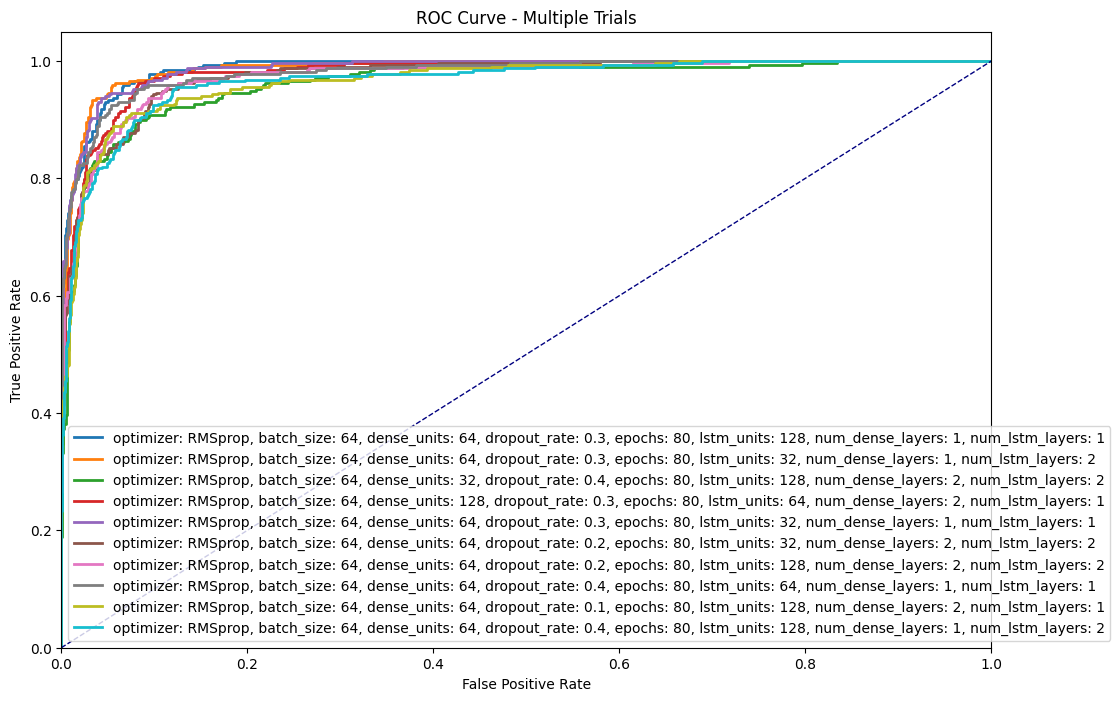

In [9]:
from typing import List
from tensorflow.keras.models import load_model

class CustomKerasModel(Sequential):
    def __init__(self, trial_id=None, **kwargs):
        super().__init__(**kwargs)
        self.trial_id = trial_id

def load_models_from_directory(directory_path: str) -> List[Sequential]:
    model_files = [name for name in os.listdir(directory_path) if name.endswith('.h5')]
    models = []
    for model_file in model_files:
        model_path = os.path.join(directory_path, model_file)
        model = load_model(model_path, custom_objects={'CustomKerasModel': CustomKerasModel})
        models.append(model)
    return models

def load_params(directory_path):
    param_file = os.path.join(directory_path, 'params.json')
    with open(param_file) as f:
        params = json.load(f)
    return params


def calculate_avg_probabilities(models: List[Sequential], X_test: np.ndarray) -> np.ndarray:
    # Initialize as zeros of type float64 with the number of samples
    avg_probabilities = np.zeros((X_test.shape[0],), dtype=np.float64)
    for model in models:
        y_prob = model.predict(X_test)
        avg_probabilities += y_prob.squeeze()  # Removes any unnecessary dimensions
    avg_probabilities /= len(models)
    return avg_probabilities

def plot_roc_curves(all_fpr, all_tpr, labels):
    plt.figure(figsize=(12, 8))
    for fpr, tpr, label in zip(all_fpr, all_tpr, labels):
        plt.plot(fpr, tpr, lw=2, label=label)

    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Multiple Trials')
    plt.legend(loc='best')
    plt.show()


def main():
    root_directory = '/root/ray_results'
    experiment_directories = [name for name in os.listdir(root_directory) if os.path.isdir(os.path.join(root_directory, name))]

    all_fpr = []
    all_tpr = []
    labels = []

    for experiment_directory in experiment_directories:
        experiment_path = os.path.join(root_directory, experiment_directory)
        trial_directories = [name for name in os.listdir(experiment_path) if os.path.isdir(os.path.join(experiment_path, name))]

        for trial_directory in trial_directories:
            trial_path = os.path.join(experiment_path, trial_directory, 'ray_results', 'trial_None')

            models = load_models_from_directory(trial_path)
            if not models:
                continue

            # Read the params.json file
            with open(os.path.join(experiment_path, trial_directory, 'params.json'), 'r') as f:
                params = json.load(f)
                
            # Create a label using only certain parameters
            parameters_of_interest = ["optimizer", "batch_size", "dense_units", "dropout_rate", "epochs", "lstm_units", "num_dense_layers", "num_lstm_layers"]
            params_str = ", ".join(f"{key}: {params[key]}" for key in parameters_of_interest)
            label = f"{params_str}"
            labels.append(label)

            avg_probabilities = calculate_avg_probabilities(models, X_test)
            fpr, tpr, _ = roc_curve(y_test, avg_probabilities)
            all_fpr.append(fpr)
            all_tpr.append(tpr)

    plot_roc_curves(all_fpr, all_tpr, labels)



if __name__ == "__main__":
    main()
